In [119]:
import pandas as pd 
import numpy as np
import warnings
import sys
sys.path.append('../')
# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
# Modelos y precision
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error,  mean_absolute_error, r2_score #Regresion
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [120]:
from utils.funciones import apply_onehot_encoder

## CARGA Y LECTURA DE DATOS

In [121]:
df = pd.read_csv('../data/processed/DatosLimpios.csv') 

In [122]:
df

,Name,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Edad
0,Hyundai,Pune,41000,Diesel,Manual,3,19.67,1582.0,126.20,5.0,12.50,9
1,Honda,Chennai,46000,Petrol,Manual,3,9.75,1199.0,88.70,5.0,4.50,13
2,Maruti,Chennai,87000,Diesel,Manual,3,20.77,1248.0,88.76,7.0,6.00,12
3,Audi,Coimbatore,40670,Diesel,Automatic,2,15.20,1968.0,140.80,5.0,17.74,11
4,Nissan,Jaipur,86999,Diesel,Manual,3,23.08,1461.0,63.10,5.0,3.50,11
...,...,...,...,...,...,...,...,...,...,...,...,...
5802,Maruti,Delhi,27365,Diesel,Manual,3,28.40,1248.0,74.00,5.0,4.75,10
5803,Hyundai,Jaipur,100000,Diesel,Manual,3,24.40,1120.0,71.00,5.0,4.00,9
5804,Mahindra,Jaipur,55000,Diesel,Manual,2,14.00,2498.0,112.00,8.0,2.90,12
5805,Maruti,Kolkata,46000,Petrol,Manual,3,18.90,998.0,67.10,5.0,2.65,11


# SELECCION DE VARIABLES

In [123]:
#numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
#numeric_df = df[numeric_cols]

Realizamos la matriz de correlacion de Pearson

In [124]:
numeric_df.corr()

,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Edad
Kilometers_Driven,1.000000,-0.230460,0.026275,0.137274,0.013335,0.216340,-0.003443,-0.151082,0.519991
Owner_Type,-0.230460,1.000000,0.018131,-0.031040,-0.023288,0.004919,-0.049794,0.052413,-0.325707
Mileage,0.026275,0.018131,1.000000,-0.629252,-0.534014,-0.393840,-0.374001,-0.430773,0.100531
Engine,0.137274,-0.031040,-0.629252,1.000000,0.852293,0.412081,0.723666,0.694858,-0.010370
Power,0.013335,-0.023288,-0.534014,0.852293,1.000000,0.071671,0.871094,0.776023,0.022760
Seats,0.216340,0.004919,-0.393840,0.412081,0.071671,1.000000,-0.013832,0.042496,-0.074621
New_Price,-0.003443,-0.049794,-0.374001,0.723666,0.871094,-0.013832,1.000000,0.871256,0.025263
Price,-0.151082,0.052413,-0.430773,0.694858,0.776023,0.042496,0.871256,1.000000,-0.224598
Edad,0.519991,-0.325707,0.100531,-0.010370,0.022760,-0.074621,0.025263,-0.224598,1.000000


Las variables con la correlacion mas alta con la variable objetivo son las siguientes en su orden: 'Price', 'Power', 'Engine'. De momento descartamos las demas variables numericas del dataframe.

In [125]:
#df_model = df[['Name', 'Location', 'Fuel_Type', 'Transmission', 'Price', 'Power', 'Engine', 'New_Price']]

In [126]:
#df_model.head()

# Division de Datos (X e y)

In [127]:
#X = df_model.drop(columns=['New_Price', 'Name', 'Location'], axis=1)
#y = df_model['New_Price']

X = df.drop(columns=['Price'], axis=1)
y = df['Price']

### DIVIDIMOS EL DATASET

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### PCA

Escalamos primero las variables continuas que vamos a usar en el PCA

Aplicmos la estandarizacion a las variables de Train

In [129]:
var_ss = ['Kilometers_Driven', 'Mileage', 'Power',	'Engine']
SS = StandardScaler()
X_train[var_ss] = SS.fit_transform(X_train[var_ss])

Aplicamos lo mismo para Test

In [130]:
X_test[var_ss] = SS.transform(X_test[var_ss])

In [131]:
X_train.shape

(4645, 11)

In [132]:
X_test.shape

(1162, 11)

In [133]:
# Aplicar PCA al conjunto de entrenamiento
train_data = X_train[var_ss]
pca_train = PCA(n_components=2)
train_data_pca = pca_train.fit_transform(train_data)

# Crear un nuevo DataFrame con los componentes principales del conjunto de entrenamiento
columns_pca_train = [f"PC{i+1}_train" for i in range(pca_train.n_components_)]
df_train_pca = pd.DataFrame(train_data_pca, columns=columns_pca_train)

X_train_reset = X_train.reset_index(drop=True)
# Concatenar los componentes principales con el DataFrame de entrenamiento original
X_train_PCA = pd.concat([X_train_reset, df_train_pca], axis=1)

# Eliminar las variables originales después de la concatenación
X_train_PCA = X_train_PCA.drop(var_ss, axis=1)

# Imprimir el DataFrame combinado para entrenamiento
X_train_PCA

,Name,Location,Fuel_Type,Transmission,Owner_Type,Seats,Edad,PC1_train,PC2_train
0,Audi,Hyderabad,Diesel,Automatic,3,5.0,11,0.891229,0.379969
1,BMW,Kochi,Diesel,Automatic,3,5.0,6,0.894152,-0.378066
2,Mahindra,Kolkata,Diesel,Manual,3,7.0,11,1.111646,-0.217910
3,Maruti,Hyderabad,Petrol,Manual,2,5.0,10,-1.108014,-0.176837
4,Ford,Bangalore,Diesel,Manual,1,7.0,13,1.820038,0.010322
...,...,...,...,...,...,...,...,...,...
4640,Hyundai,Hyderabad,Petrol,Manual,3,5.0,20,0.296344,0.497668
4641,Hyundai,Hyderabad,Petrol,Manual,3,5.0,14,-0.637867,0.314866
4642,Maruti,Chennai,Petrol,Automatic,3,5.0,7,-1.252822,-0.071935
4643,Maruti,Hyderabad,Diesel,Manual,2,5.0,9,-1.630123,0.004420


In [134]:
# Aplicar PCA al conjunto de prueba
test_data = X_test[var_ss]
pca_test = PCA(n_components=2)
test_data_pca = pca_test.fit_transform(test_data)

# Crear un nuevo DataFrame con los componentes principales del conjunto de prueba
columns_pca_test = [f"PC{i+1}_test" for i in range(pca_test.n_components_)]
df_test_pca = pd.DataFrame(test_data_pca, columns=columns_pca_test)

X_test_reset = X_test.reset_index(drop=True)
# Concatenar los componentes principales con el DataFrame de prueba original
X_test_PCA = pd.concat([X_test_reset, df_test_pca], axis=1)

# Eliminar las variables originales después de la concatenación
X_test_PCA = X_test_PCA.drop(var_ss, axis=1)

# Imprimir el DataFrame combinado para prueba
X_test_PCA

,Name,Location,Fuel_Type,Transmission,Owner_Type,Seats,Edad,PC1_test,PC2_test
0,Audi,Coimbatore,Diesel,Automatic,3,5.0,7,0.992412,-0.646476
1,Maruti,Delhi,Petrol,Manual,2,5.0,14,-0.696071,0.562650
2,Hyundai,Mumbai,Petrol,Manual,3,5.0,8,-1.881302,0.289309
3,Maruti,Jaipur,Petrol,Manual,3,5.0,5,-2.443848,-0.336405
4,BMW,Delhi,Petrol,Automatic,3,5.0,13,2.816799,0.042608
...,...,...,...,...,...,...,...,...,...
1157,Renault,Kolkata,Diesel,Manual,3,5.0,10,-0.383659,-0.065311
1158,Skoda,Kochi,Petrol,Automatic,3,5.0,8,1.152490,0.358995
1159,Mercedes-Benz,Coimbatore,Diesel,Automatic,3,5.0,7,0.923244,-0.998248
1160,Mini,Mumbai,Diesel,Automatic,3,5.0,8,-0.516328,-0.483771


### Tratamiento variables categoricas

### LabelEncoder

In [142]:
#Realizamos la transformacion de la variable 'Name' del conjunto Train
var_LE = ['Name', 'Location', 'Fuel_Type', 'Transmission']
le = LabelEncoder()
#for col in var_LE:
#    X_train_PCA[col] = le.fit_transform(X_train_PCA[col])

for col in var_LE:
    X_train[col] = le.fit_transform(X_train[col])

In [143]:
#Realizamos la transformacion de la variable 'Name' del conjunto Test

#for col in var_LE:
#    X_test_PCA[col] = le.fit_transform(X_test_PCA[col])

for col in var_LE:
    X_test[col] = le.fit_transform(X_test[col])

### OHE

In [114]:
var_1he = ['Location', 'Fuel_Type',	'Transmission']
#var_1he = ['Fuel_Type',	'Transmission']

#X_train_PCA, X_test_PCA = apply_onehot_encoder(X_train_PCA, var_1he, X_test_PCA)

### Ensayo los modelos y sus metricas

In [ ]:
# Definir modelos a evaluar
models = {'Linear Regression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'ElasticNet' : ElasticNet(),
    'Bayes' : BayesianRidge(),
    'DecisionTreeRegressor'  : DecisionTreeRegressor(),
    'Random Forest Regressor' : RandomForestRegressor(),
    'GradientBootingRegressor' : GradientBoostingRegressor(),
    'SVR' : SVR(),
    'KNRegressor' : KNeighborsRegressor(),
    'XGBRegressor' : XGBRegressor(),
    'LGBMRegressor' : LGBMRegressor(),
    'CatBoostRegressor' : CatBoostRegressor(verbose=False)}

# Definir métricas de evaluación
metrics = {
    'Mean Squared Error': mean_squared_error,
    'Mean Absolute Error': mean_absolute_error,
    'R2 Score' : r2_score
}

# Configurar la validación cruzada (k-fold cross-validation)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Ciclo para evaluar modelos y métricas
results = []
for model_name, model in models.items():
    print(f"Modelo: {model_name}")
    for metric_name, metric_func in metrics.items():
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
        scores = -scores  # Convertir de negativo a positivo para errores cuadráticos
        mean_score = np.mean(scores)
        print(f"{metric_name}: {mean_score}")
        results.append({'Model': model_name, 'Metric': metric_name, 'Score': mean_score})
    print("\n")

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)
print("Resultados Finales:")
print(results_df)

In [ ]:
Modelo: CatBoostRegressor
Mean Squared Error: 9.966371561400479
Mean Absolute Error: 9.966371561400479
R2 Score: 9.966371561400479

In [145]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    BayesianRidge(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    KNeighborsRegressor(),
    XGBRegressor(),
    LGBMRegressor(),
    CatBoostRegressor(verbose=False)
    ]

# Create lists to store metrics
model_names = []
mae_values = []
mse_values = []
r2_values = []

# For loop to fit and evaluate each model
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    model_names.append(model_name)
    mae_values.append(mae)
    mse_values.append(mse)
    r2_values.append(r2)
    
    # Print the metrics
    print(f"Model: {model_name}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R^2): {r2:.2f}")
    print("-" * 40)


Model: LinearRegression
Mean Absolute Error (MAE): 3.79
Mean Squared Error (MSE): 34.88
R-squared (R^2): 0.69
----------------------------------------
Model: Ridge
Mean Absolute Error (MAE): 3.79
Mean Squared Error (MSE): 34.89
R-squared (R^2): 0.69
----------------------------------------
Model: Lasso
Mean Absolute Error (MAE): 3.91
Mean Squared Error (MSE): 38.20
R-squared (R^2): 0.66
----------------------------------------
Model: ElasticNet
Mean Absolute Error (MAE): 3.91
Mean Squared Error (MSE): 38.04
R-squared (R^2): 0.66
----------------------------------------
Model: BayesianRidge
Mean Absolute Error (MAE): 3.79
Mean Squared Error (MSE): 34.95
R-squared (R^2): 0.69
----------------------------------------
Model: DecisionTreeRegressor
Mean Absolute Error (MAE): 2.23
Mean Squared Error (MSE): 26.24
R-squared (R^2): 0.77
----------------------------------------
Model: RandomForestRegressor
Mean Absolute Error (MAE): 1.68
Mean Squared Error (MSE): 16.97
R-squared (R^2): 0.85
-----

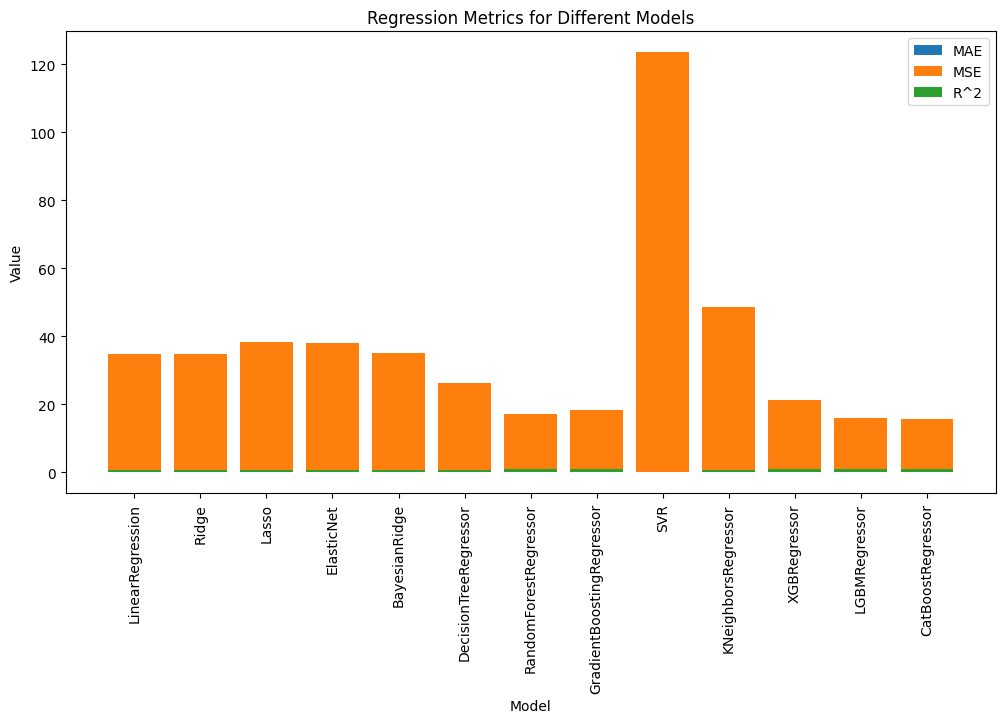

In [146]:
# Plot the metrics
plt.figure(figsize=(12, 6))
plt.bar(model_names, mae_values, label='MAE')
plt.bar(model_names, mse_values, label='MSE')
plt.bar(model_names, r2_values, label='R^2')
plt.legend()
plt.title('Regression Metrics for Different Models')
plt.xlabel('Model')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

In [148]:
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)

feature_importance = lgbm_model.feature_importances_

# Crear un DataFrame para visualizar las importancias
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Imprimir el DataFrame con las importancias de las características
feature_importance_df


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 4645, number of used features: 11
[LightGBM] [Info] Start training from score 9.676982


,Feature,Importance
8,Power,718
6,Mileage,560
10,Edad,365
2,Kilometers_Driven,342
0,Name,307
7,Engine,273
1,Location,261
4,Transmission,62
3,Fuel_Type,49
9,Seats,45


In [34]:
#Definimos los modelos a usar para la clasificacion
modelos = {'Linear Regression' : LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso' : Lasso(),
    'ElasticNet' : ElasticNet(),
    'Bayes' : BayesianRidge(),
    'DecisionTreeRegressor'  : DecisionTreeRegressor(),
    'Random Forest Regressor' : RandomForestRegressor(),
    'GradientBootingRegressor' : GradientBoostingRegressor(),
    'SVR' : SVR(),
    'KNRegressor' : KNeighborsRegressor(),
    'XGBRegressor' : XGBRegressor(),
    'LGBMRegressor' : LGBMRegressor(),
    'CatBoostRegressor' : CatBoostRegressor(verbose=False)}
    
#Definimos las metricas 
metricas = ['R2_Values', 'MAE', 'MSE', 'MAPE']

#Cross Validation
resultados = {}

for nombre_modelo, modelo in modelos.items():
    cv_resultados = cross_validate(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    resultados_metricas = {metrica : cv_resultados[f'test_{metrica}'].mean() for metrica in metricas}

    resultados[nombre_modelo] = resultados_metricas

#Convertir el diccionario en DataFrame
resultados_df = pd.DataFrame(resultados).T

KeyError: 'test_R2_Values'